In [25]:
ACTIVITY_LABELS = {
    1: "sitting",
    2: "standing",
    3: "lying on back",
    4: "lying on right side",
    5: "ascending stairs",
    6: "descending stairs",
    7: "standing in elevator still",
    8: "moving in elevator",
    9: "walking in parking lot",
    10: "walking on treadmill (flat)",
    11: "walking on treadmill (inclined)",
    12: "running on treadmill",
    13: "exercising on stepper",
    14: "exercising on cross trainer",
    15: "cycling (horizontal)",
    16: "cycling (vertical)",
    17: "rowing",
    18: "jumping",
    19: "playing basketball"
}

In [26]:
import joblib
# a helper function to save the model for later use
def save_model(model, model_name):
    model_path = f'processed_data/{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model, model_path)
    print(f"\nModel saved to: {model_path}")

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# a helper function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="rf"):
    """
    Plot confusion matrix for model predictions
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str, default="Model"
        Name of the model for plot title
    """
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[ACTIVITY_LABELS[i] for i in range(1, 20)],
                yticklabels=[ACTIVITY_LABELS[i] for i in range(1, 20)])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [28]:
from sklearn.model_selection import cross_val_score

# For storing cross-validation scores across all folds for all models
cv_results = {}

def perform_cross_validation(model, X, y, cv=5):
    """
    Perform 10-fold cross validation on the given model and return its scores
    """
    cv_scores = cross_val_score(model, X, y, cv = cv, scoring = 'accuracy')
    
    return cv_scores

In [29]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, title="Learning Curve"):
    """
    Plot learning curve for given model to visualize performance trend against data size changes
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=3, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross Validation Score')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve_for_model(model, X_test, y_test, activity_labels, model_name="rf"):
    """
    Plot ROC curve for given model to analyze true versus false positives across all activities
    """
    # Binary encode activity labels to be appropriate format for ROC curve
    y_test_binary = label_binarize(y_test, classes=list(activity_labels.keys()))
    
    plt.figure(figsize=(10, 8))

    y_score = model.predict_proba(X_test)

    # Dictionaries to store false positives, true positives, and AUC for each activity
    fp, tp, roc_auc = {}, {}, {}

    # Compute and plot ROC curve for each activity
    for i in range(len(activity_labels)):
        fp[i], tp[i], _ = roc_curve(y_test_binary[:, i], y_score[:, i])
        roc_auc[i] = auc(fp[i], tp[i])
        plt.plot(fp[i], tp[i], label=f"Class {i + 1} ({activity_labels[i + 1]}) - AUC = {roc_auc[i]:.2f}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = "best")
    plt.show()


In [31]:
from sklearn.metrics import classification_report

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Train and evaluate a machine learning model
    """
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} trained successfully")

    # Make predictions
    print(f"Making predictions with {model_name}...")
    y_pred = model.predict(X_test)
    print(f"{model_name} predictions made successfully")
    
    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[ACTIVITY_LABELS[i] for i in range(1, 20)]))
    print("-" * 50)

    # Perform Cross Validation
    cross_val_scores = perform_cross_validation(model, X_train, y_train)
    print(f"Cross Validation scores for {model_name}: {cross_val_scores}")
    print(f"Mean Score: {np.mean(cross_val_scores):.4f}\nStandard Deviation: {np.std(cross_val_scores):.4f}")

    # Save model
    save_model(model, model_name)
    
    # Plot confusion matrix using helper function
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Plot learning curve using helper function
    plot_learning_curve(model, X_train, y_train, title = f"{model_name} Learning Curve")

    # Plot ROC curve using helper function
    plot_roc_curve_for_model(model, X_test, y_test, ACTIVITY_LABELS, model_name = model_name)
    
    return model, cross_val_scores

In [32]:
def rf_plot_feature_importance(model, features):
    """
    Plot feature importance for Random Forest model.
    """
    importances = model.feature_importances_
    sorted_indices = importances.argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in sorted_indices], rotation=90)
    plt.title(f'Feature Importance - Random Forest')
    plt.show()

In [33]:
def get_column_names():
    """Generate column names for the sensor data."""
    units = ['T', 'RA', 'LA', 'RL', 'LL']
    sensors = ['acc_x', 'acc_y', 'acc_z', 
              'gyro_x', 'gyro_y', 'gyro_z',
              'mag_x', 'mag_y', 'mag_z']
    
    columns = []
    for unit in units:
        for sensor in sensors:
            columns.append(f"{unit}_{sensor}")
    
    return columns

In [34]:
# Load the preprocessed data
X_train = np.load('processed_data/X_train.npy')
X_test = np.load('processed_data/X_test.npy')
y_train = np.load('processed_data/y_train.npy')
y_test = np.load('processed_data/y_test.npy')


Training trained_random_forest_model...
trained_random_forest_model trained successfully
Making predictions with trained_random_forest_model...
trained_random_forest_model predictions made successfully

trained_random_forest_model Classification Report:
                                 precision    recall  f1-score   support

                        sitting       1.00      1.00      1.00     12000
                       standing       1.00      1.00      1.00     12000
                  lying on back       1.00      1.00      1.00     12000
            lying on right side       1.00      1.00      1.00     12000
               ascending stairs       1.00      0.95      0.97     12000
              descending stairs       0.94      1.00      0.97     12000
     standing in elevator still       1.00      1.00      1.00     12000
             moving in elevator       1.00      1.00      1.00     12000
         walking in parking lot       1.00      1.00      1.00     12000
    walking on

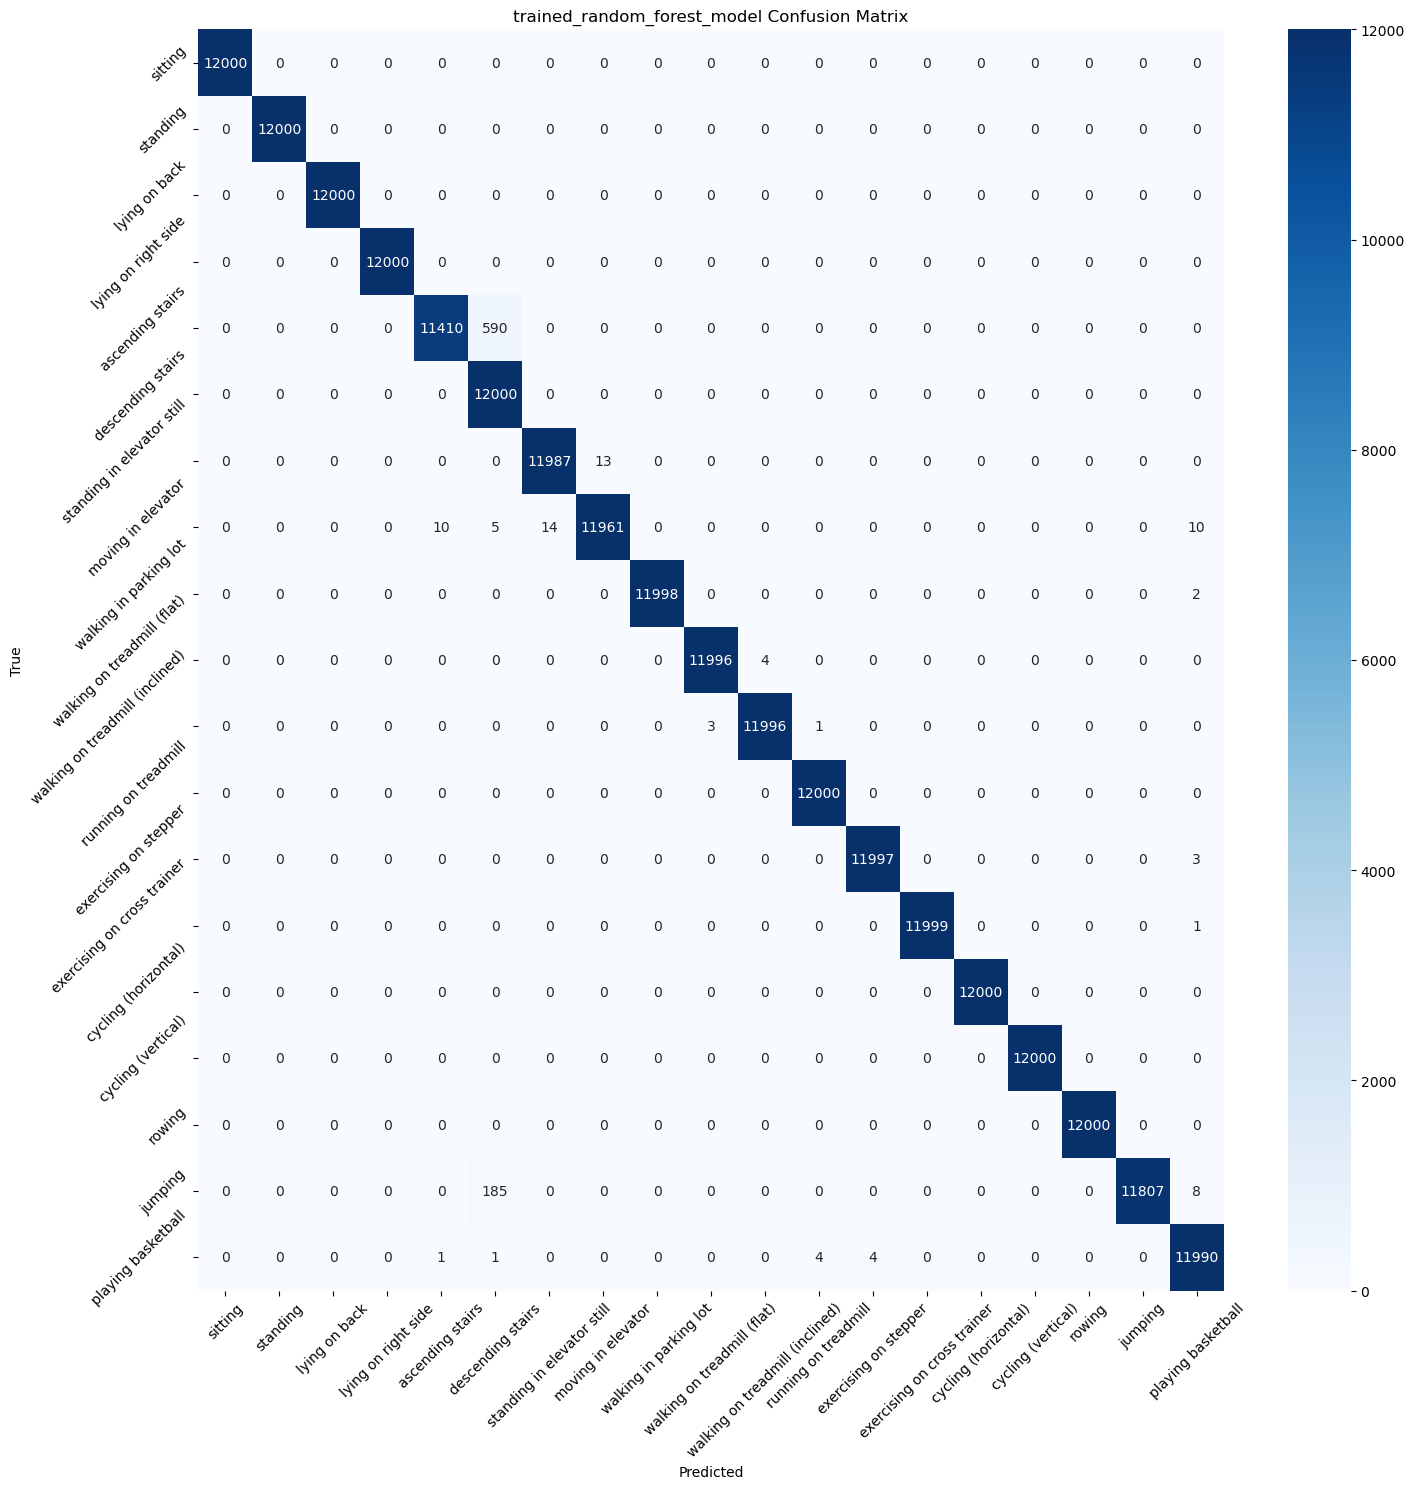

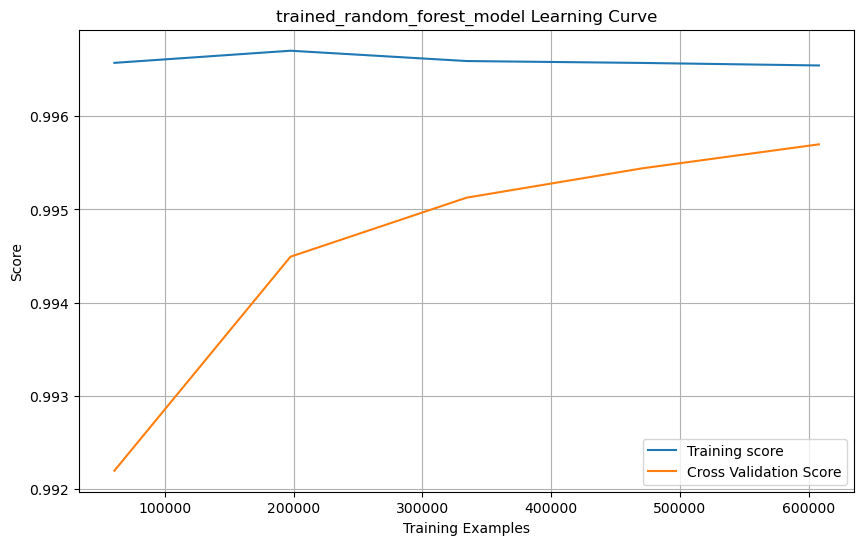

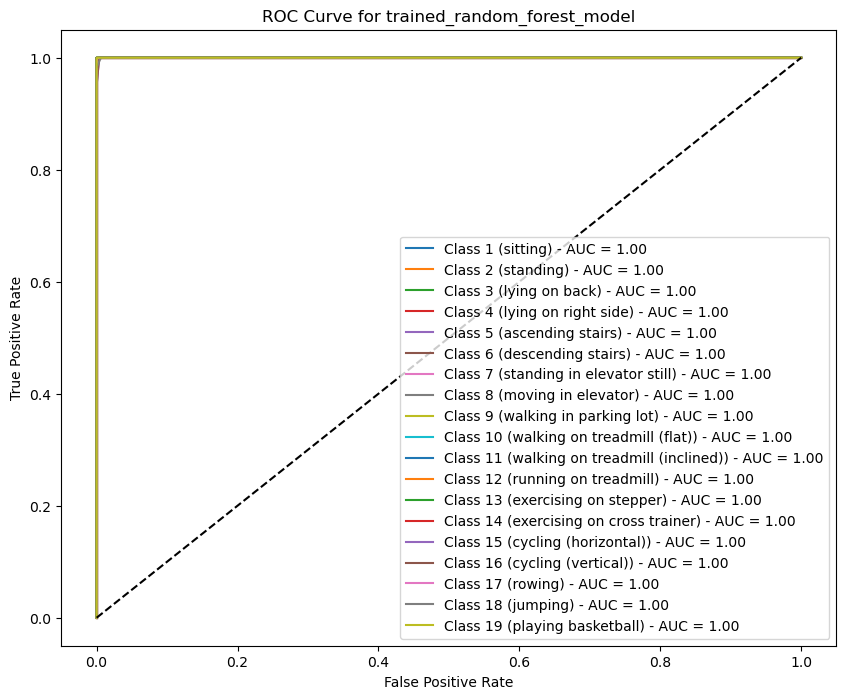

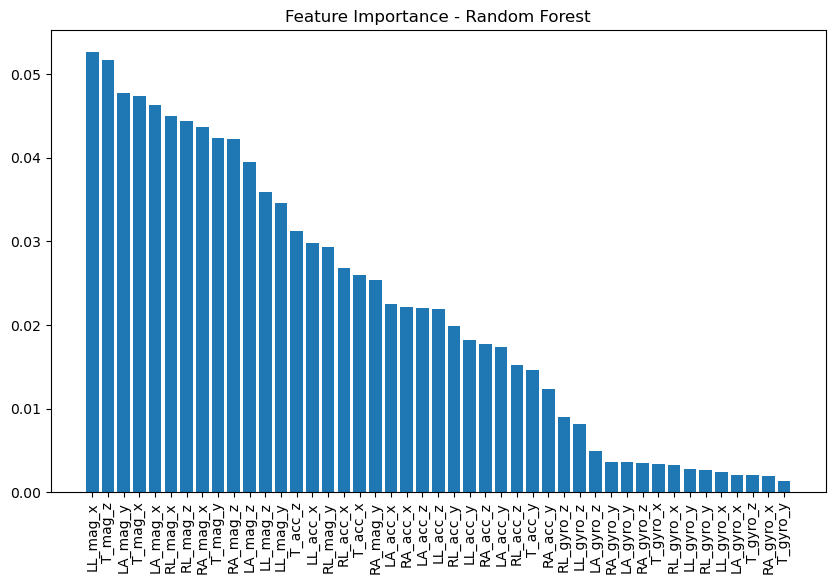

In [35]:
# 1. Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model, cross_val_scores = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "trained_random_forest_model")
cv_results['Random Forest'] = cross_val_scores

features = get_column_names()
rf_plot_feature_importance(rf_model, features)



Training SVM on subset of data...

Training trained_svm_model...
trained_svm_model trained successfully
Making predictions with trained_svm_model...
trained_svm_model predictions made successfully

trained_svm_model Classification Report:
                                 precision    recall  f1-score   support

                        sitting       1.00      1.00      1.00       521
                       standing       0.99      1.00      1.00       525
                  lying on back       1.00      1.00      1.00       535
            lying on right side       1.00      1.00      1.00       523
               ascending stairs       0.97      0.95      0.96       526
              descending stairs       0.90      0.99      0.95       530
     standing in elevator still       0.84      0.98      0.90       547
             moving in elevator       0.96      0.73      0.83       538
         walking in parking lot       0.96      0.99      0.98       479
    walking on treadmill (fla

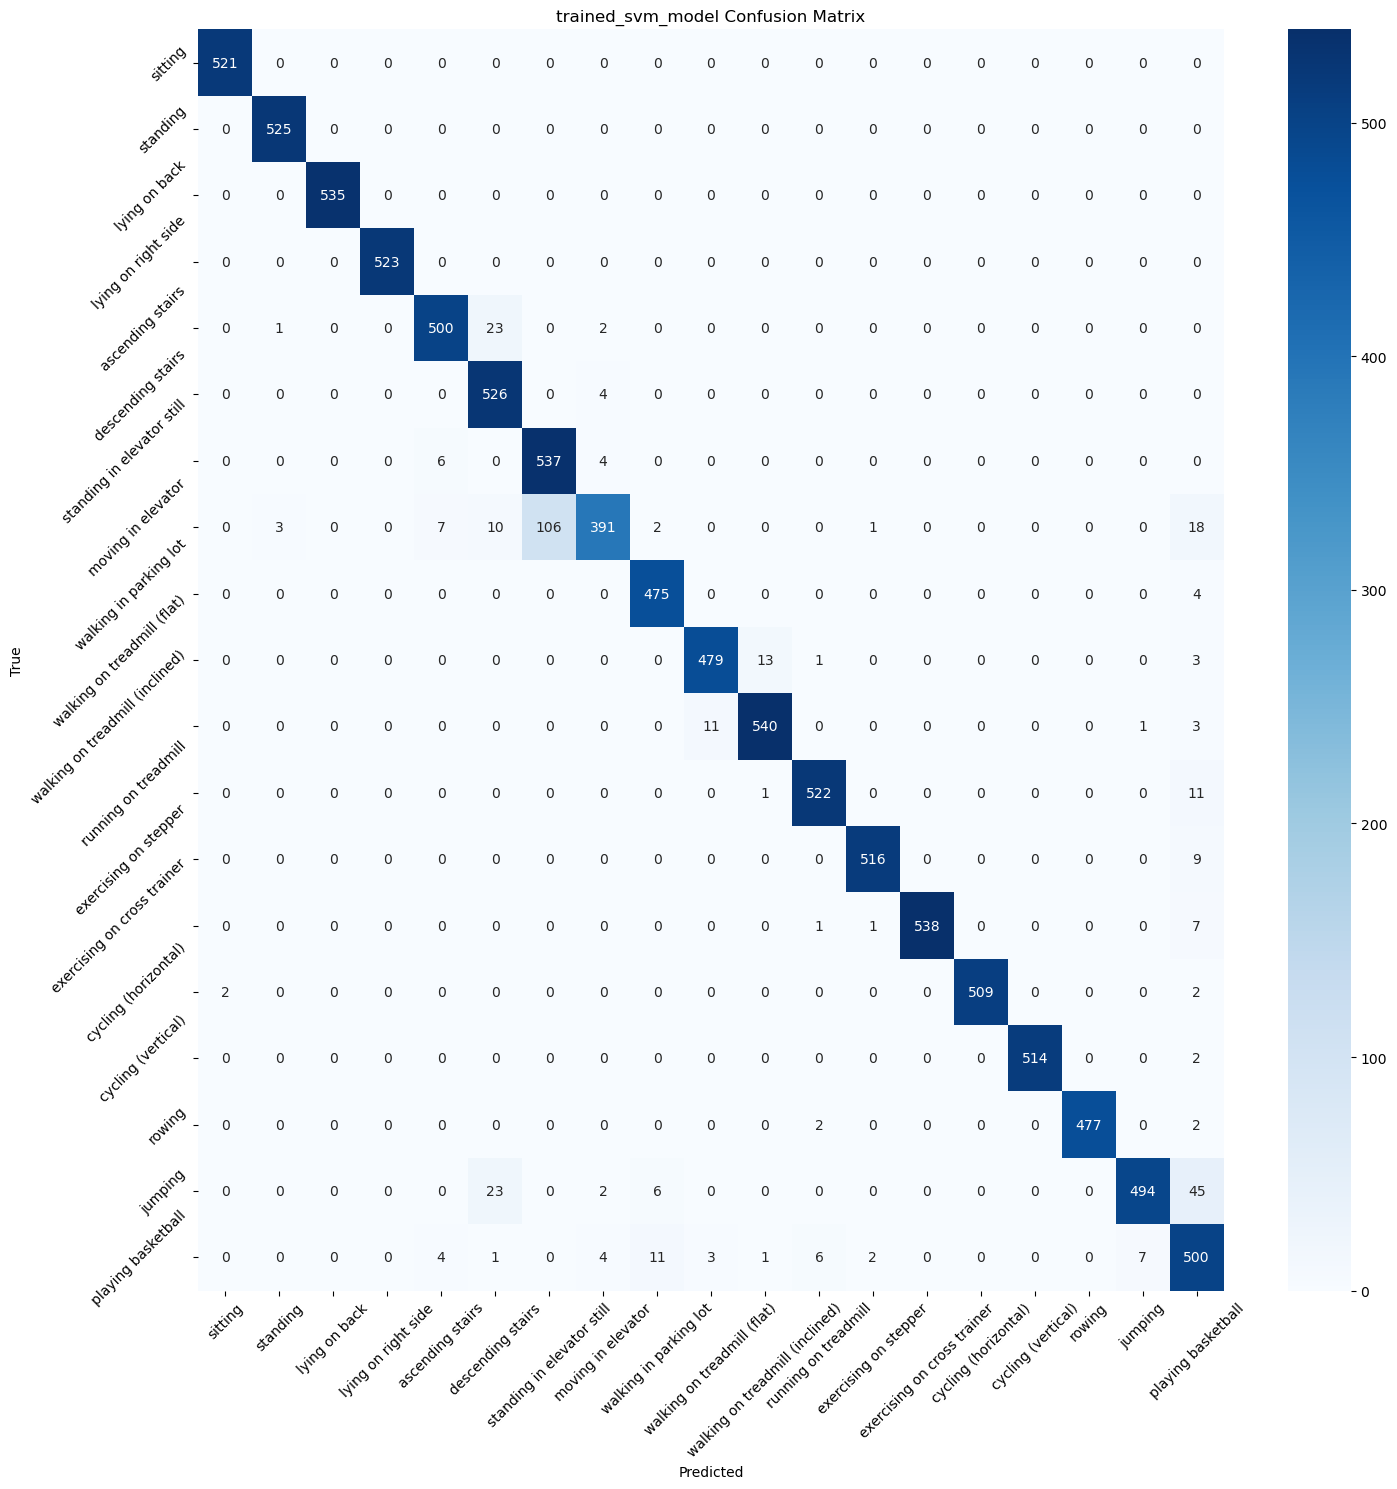

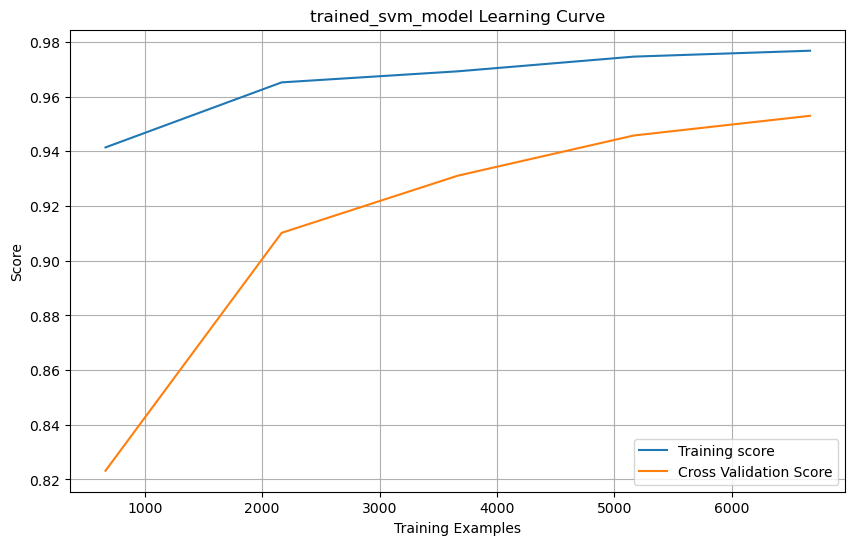

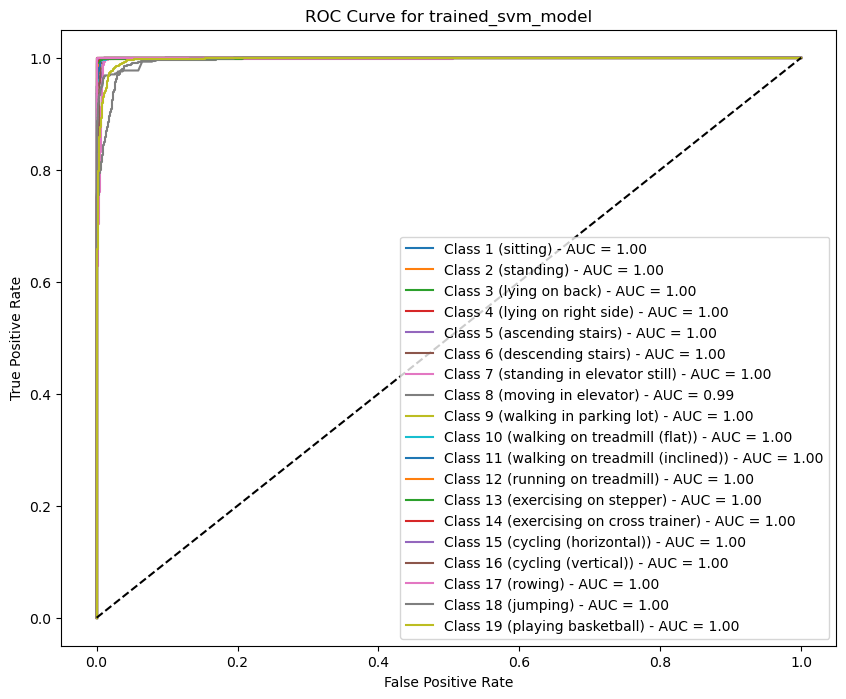

In [36]:
# 2. Support Vector Machine (for smaller subset due to computational complexity)
from sklearn.svm import SVC
print("\nTraining SVM on subset of data...")
subset_size = 10000
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model, cross_val_scores = train_and_evaluate_model(
    svm_model, 
    X_train[:subset_size], 
    X_test[:subset_size], 
    y_train[:subset_size], 
    y_test[:subset_size],
    "trained_svm_model"
)
cv_results['SVM'] = cross_val_scores


Training trained_neural_network_model...
trained_neural_network_model trained successfully
Making predictions with trained_neural_network_model...
trained_neural_network_model predictions made successfully

trained_neural_network_model Classification Report:
                                 precision    recall  f1-score   support

                        sitting       1.00      1.00      1.00     12000
                       standing       1.00      1.00      1.00     12000
                  lying on back       1.00      1.00      1.00     12000
            lying on right side       1.00      1.00      1.00     12000
               ascending stairs       0.94      1.00      0.97     12000
              descending stairs       1.00      0.95      0.97     12000
     standing in elevator still       1.00      0.99      0.99     12000
             moving in elevator       0.99      1.00      0.99     12000
         walking in parking lot       1.00      1.00      1.00     12000
    walki

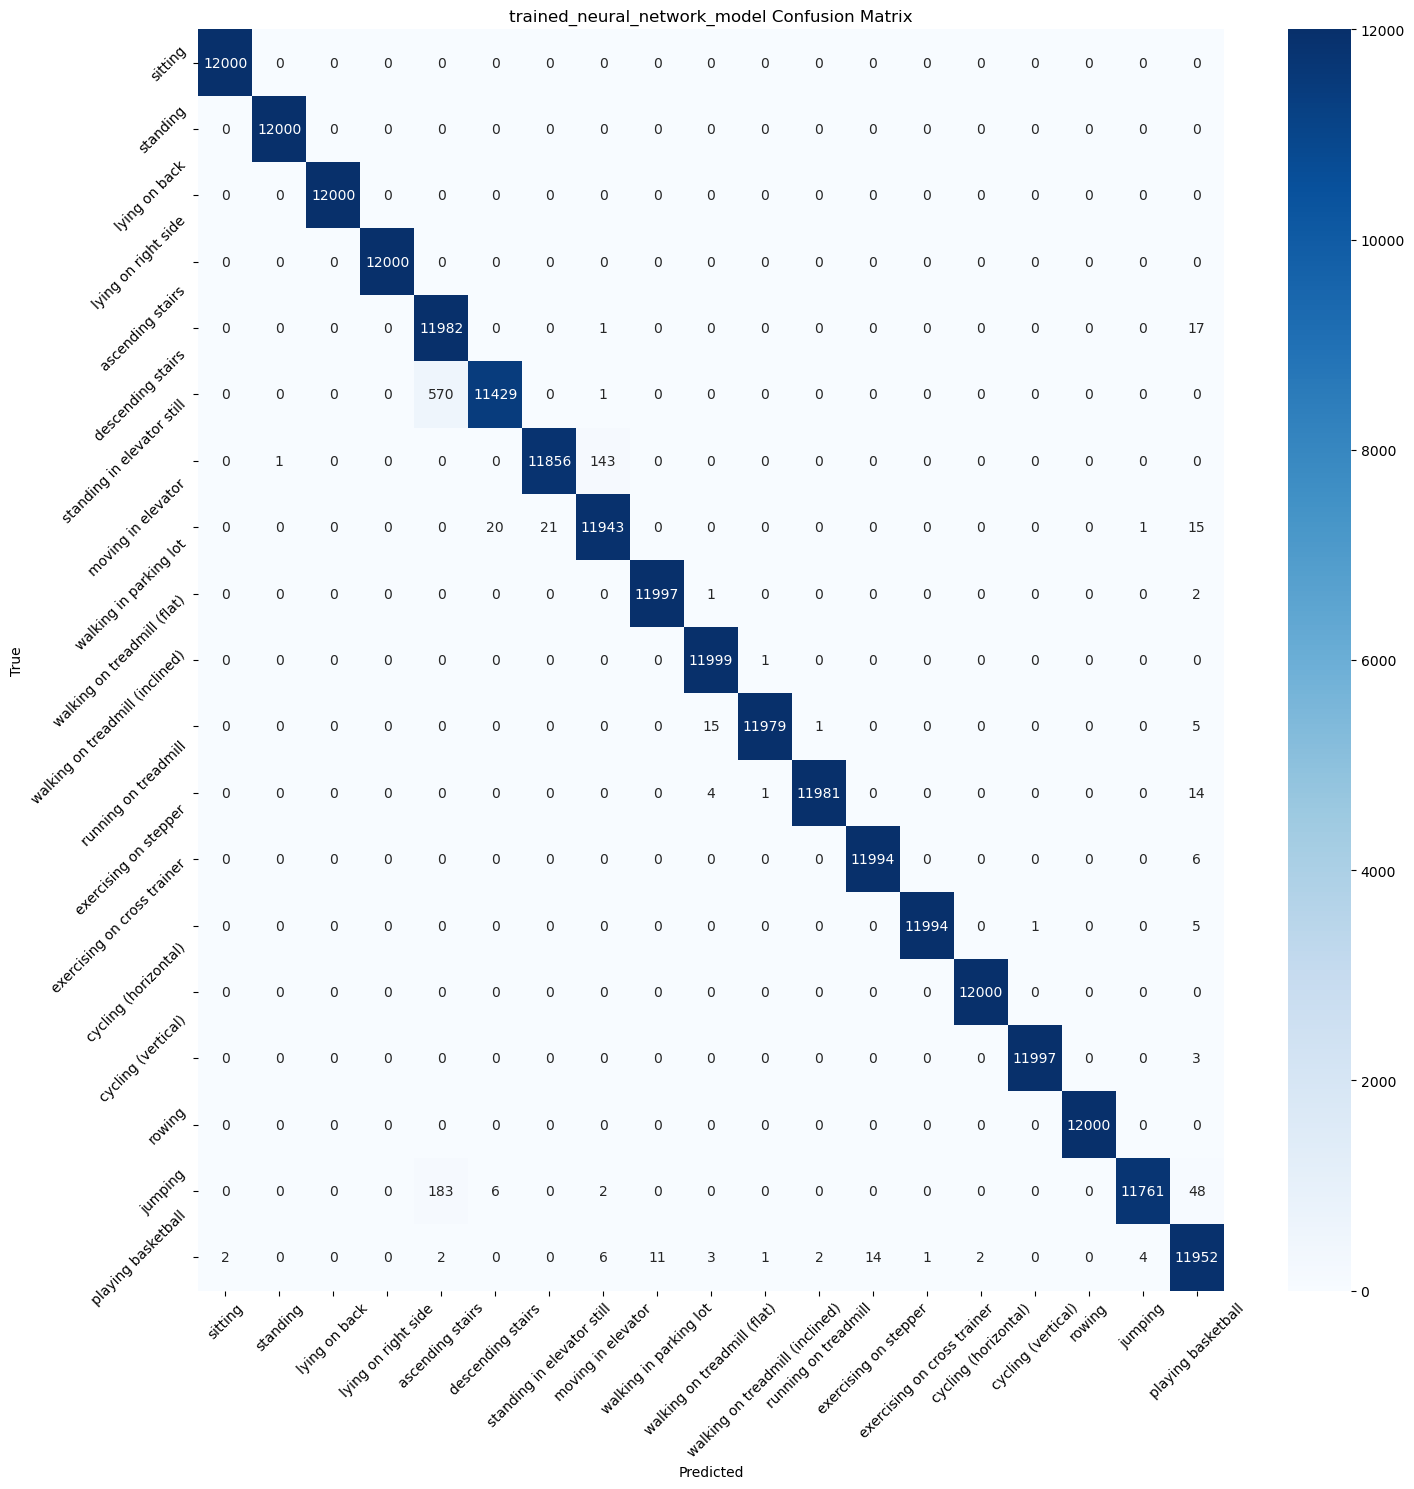

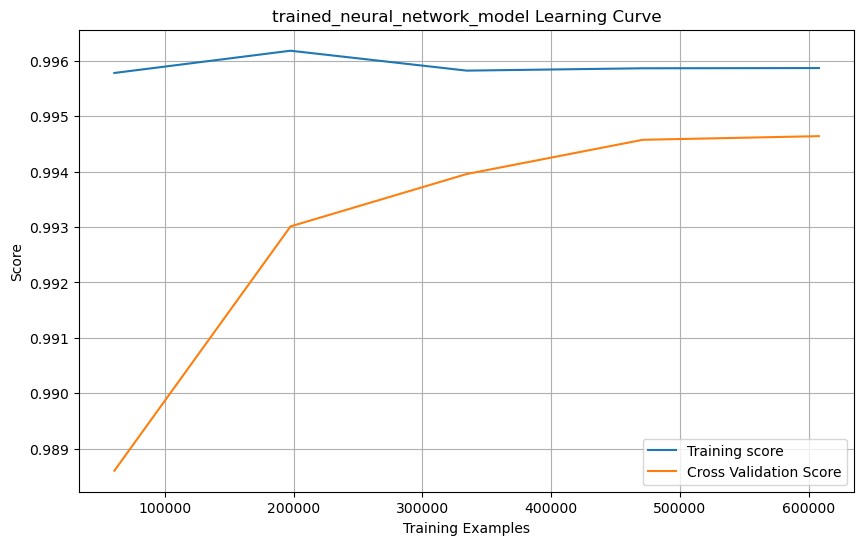

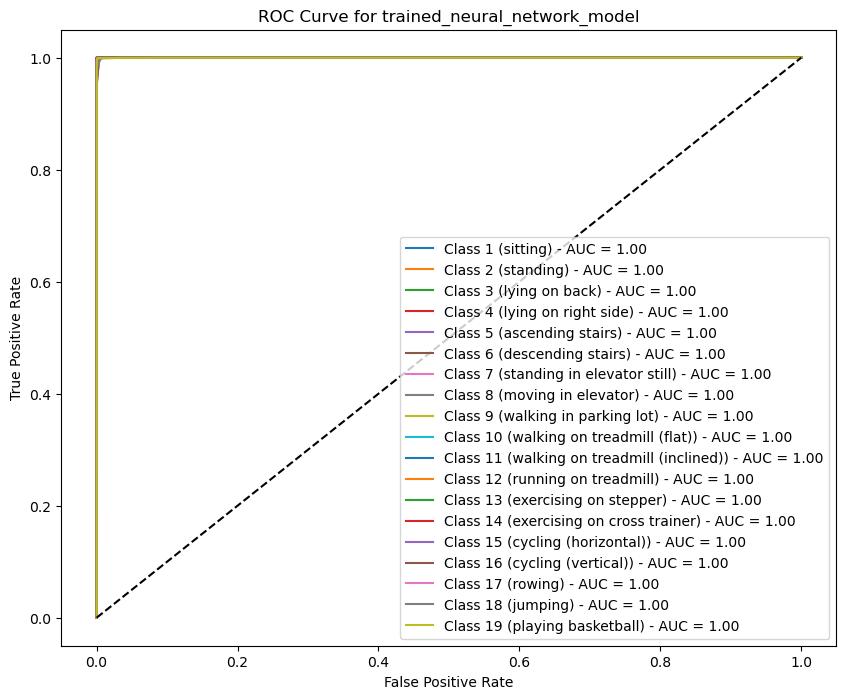

In [37]:
# 3. Neural Network
# NOTE: this takes a long time to train, (2 hours on 32GB RAM macbook pro)
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    random_state=42
)

nn_model, cross_val_scores = train_and_evaluate_model(nn_model, X_train, X_test, y_train, y_test, "trained_neural_network_model")
cv_results['Neural Network'] = cross_val_scores

In [38]:
import pandas as pd

# Convert dictionary storing cross-validation scores into dataframe for table display
cv_df = pd.DataFrame.from_dict(cv_results, orient = 'index')

cv_df.columns = [f"Fold {i+1}" for i in range(5)]

# Get mean and std dev across all folds
cv_df["Mean"] = cv_df.mean(axis=1)
cv_df["Std Dev"] = cv_df.std(axis=1)

# Generalization analysis across models
print("Cross Validation Table Comparison between Models:")
print(cv_df)

Cross Validation Table Comparison between Models:
                  Fold 1    Fold 2    Fold 3    Fold 4    Fold 5      Mean  \
Random Forest   0.995636  0.995921  0.996009  0.995773  0.995850  0.995838   
SVM             0.959000  0.952000  0.960000  0.954000  0.958000  0.956600   
Neural Network  0.994863  0.994737  0.995362  0.994677  0.995016  0.994931   

                 Std Dev  
Random Forest   0.000127  
SVM             0.003072  
Neural Network  0.000245  


In [39]:
import joblib
# 1. Load the saved model (if you saved it previously)
rf_model = joblib.load('processed_data/trained_random_forest_model.pkl')

# 2. Make predictions
def predict_activity_rf(model, X_sample):
    """
    Predict activity using Random Forest
    X_sample: numpy array of shape (n_samples, n_features)
    """
    # Make prediction
    prediction = model.predict(X_sample)
    # Get probability scores for each class
    probabilities = model.predict_proba(X_sample)
    
    # Get top 3 predictions with their probabilities
    for i, pred in enumerate(prediction):
        top_3_indices = np.argsort(probabilities[i])[-3:][::-1]
        print(f"\nSample {i+1} Predictions:")
        for idx in top_3_indices:
            activity_name = ACTIVITY_LABELS[idx + 1]  # +1 because labels start from 1
            probability = probabilities[i][idx]
            print(f"{activity_name}: {probability:.2%}")
    
    return prediction, probabilities

# Example usage:
# Take a few samples from test set
# test_samples = X_test[:5]  # First 5 samples
# predictions, probs = predict_activity_rf(rf_model, test_samples)

In [40]:
# 1. Load the saved model (if you saved it previously)
svm_model = joblib.load('processed_data/trained_svm_model.pkl')

def predict_activity_svm(model, X_sample):
    """
    Predict activity using SVM
    X_sample: numpy array of shape (n_samples, n_features)
    """
    # Ensure X_sample is 2D
    if X_sample.ndim == 1:
        X_sample = X_sample.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(X_sample)
    
    # Get probability scores
    probabilities = model.predict_proba(X_sample)
    
    # Get top 3 predictions based on probabilities
    for i, pred in enumerate(prediction):
        top_3_indices = np.argsort(probabilities[i])[-3:][::-1]
        print(f"\nSample {i+1} Predictions:")
        for idx in top_3_indices:
            activity_name = ACTIVITY_LABELS[idx + 1]  # +1 because labels start from 1
            probability = probabilities[i][idx]
            print(f"{activity_name}: {probability:.2%}")
    
    return prediction, probabilities

In [41]:
nn_model = joblib.load('processed_data/trained_neural_network_model.pkl')
def predict_activity_nn(model, X_sample):
    """
    Predict activity using Neural Network
    X_sample: numpy array of shape (n_samples, n_features)
    """
    # Ensure X_sample is 2D
    if X_sample.ndim == 1:
        X_sample = X_sample.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(X_sample)
    # Get probability scores for each class
    probabilities = model.predict_proba(X_sample)
    
    # Get top 3 predictions with their probabilities
    for i, pred in enumerate(prediction):
        top_3_indices = np.argsort(probabilities[i])[-3:][::-1]
        print(f"\nSample {i+1} Predictions:")
        for idx in top_3_indices:
            activity_name = ACTIVITY_LABELS[idx + 1]  # +1 because labels start from 1
            probability = probabilities[i][idx]
            print(f"{activity_name}: {probability:.2%}")
    
    return prediction, probabilities

In [42]:
def compare_predictions(X_samples, y_true):
    """
    Compare predictions from both models
    """
    print("Comparing RF, SVM, and NN predictions on test set:")
    print("-" * 50)
    
    rf_pred = rf_model.predict(X_samples)
    svm_pred = svm_model.predict(X_samples)
    nn_pred = nn_model.predict(X_samples)
    
    for i in range(len(X_samples)):
        true_activity = ACTIVITY_LABELS[y_true[i]]
        rf_activity = ACTIVITY_LABELS[rf_pred[i]]
        svm_activity = ACTIVITY_LABELS[svm_pred[i]]
        nn_activity = ACTIVITY_LABELS[nn_pred[i]]
        print(f"\nSample {i+1}:")
        print(f"True Activity: {true_activity}")
        print(f"Random Forest: {rf_activity}")
        print(f"SVM: {svm_activity}")
        print(f"Neural Network: {nn_activity}")

# Example usage:
test_samples = X_test[:5]
true_labels = y_test[:5]
compare_predictions(test_samples, true_labels)

Comparing RF, SVM, and NN predictions on test set:
--------------------------------------------------

Sample 1:
True Activity: exercising on stepper
Random Forest: exercising on stepper
SVM: exercising on stepper
Neural Network: exercising on stepper

Sample 2:
True Activity: standing in elevator still
Random Forest: standing in elevator still
SVM: standing in elevator still
Neural Network: standing in elevator still

Sample 3:
True Activity: lying on right side
Random Forest: lying on right side
SVM: lying on right side
Neural Network: lying on right side

Sample 4:
True Activity: lying on right side
Random Forest: lying on right side
SVM: lying on right side
Neural Network: lying on right side

Sample 5:
True Activity: cycling (horizontal)
Random Forest: cycling (horizontal)
SVM: cycling (horizontal)
Neural Network: cycling (horizontal)


In [43]:
from pathlib import Path

def compute_and_save_activity_stats():
    """
    Computes the mean and standard deviation for each feature grouped by activity
    and saves the statistics to 'activity_stats.pkl'.
    Also fits and saves a StandardScaler as 'scaler.pkl'.
    """
    # Define the path to the processed data directory
    processed_data_path = Path('processed_data')
    
    # Load feature names from feature_names.txt
    feature_names_file = processed_data_path/'feature_names.txt'
    with open(feature_names_file, 'r') as file:
        feature_names = [line.strip() for line in file.readlines()]
    
    # Load training data from x_train.npy and y_train.npy
    x_train_path = processed_data_path/'x_train.npy'
    y_train_path = processed_data_path/'y_train.npy'
    
    X_train = np.load(x_train_path)
    y_train = np.load(y_train_path)
    
    # Convert X_train to DataFrame
    df_train = pd.DataFrame(X_train, columns=feature_names)
    df_train['activity'] = y_train
    
    # Compute mean and std for each feature grouped by activity
    activity_stats = df_train.groupby('activity').agg(['mean', 'std'])
    
    # Save the activity statistics to a pickle file
    activity_stats_file = processed_data_path/'activity_stats.pkl'
    joblib.dump(activity_stats, activity_stats_file)
    print(f"Activity statistics saved to {activity_stats_file}")
    
    # Fit a StandardScaler on the training data features
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    # Save the scaler to a pickle file
    scaler_file = processed_data_path / 'scaler.pkl'
    joblib.dump(scaler, scaler_file)
    print(f"Scaler saved to {scaler_file}")

if __name__ == "__main__":
    compute_and_save_activity_stats()

Activity statistics saved to processed_data\activity_stats.pkl
Scaler saved to processed_data\scaler.pkl


In [44]:
def create_realistic_sample_data(n_samples, activity_id):
    """
    Generates realistic sample data for a given activity using training data statistics.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - activity_id (int): ID of the activity to generate data for.

    Returns:
    - pd.DataFrame: DataFrame containing the generated samples with scaled features.
    """
    # Define the path to the processed data directory
    processed_data_path = Path('processed_data')

    # Load feature names from feature_names.txt
    feature_names_file = processed_data_path/'feature_names.txt'
    with open(feature_names_file, 'r') as file:
        feature_names = [line.strip() for line in file.readlines()]

    # Load activity statistics (mean and std) from activity_stats.pkl
    activity_stats_file = processed_data_path/'activity_stats.pkl'
    activity_stats = joblib.load(activity_stats_file)

    # Check if the activity_id exists in the activity_stats
    if activity_id not in activity_stats.index:
        raise ValueError(f"Unknown activity_id: {activity_id}")

    # Retrieve mean and std for the specified activity_id
    # Assuming activity_stats has a MultiIndex with levels ['feature', 'stat']
    mean = activity_stats.loc[activity_id, (slice(None), 'mean')].values
    std = activity_stats.loc[activity_id, (slice(None), 'std')].values

    # Generate synthetic data using normal distribution
    synthetic_data = np.random.normal(loc=mean, scale=std, size=(n_samples, len(mean)))

    # Create DataFrame with generated data
    df = pd.DataFrame(synthetic_data, columns=feature_names)

    # Add additional required columns
    df['activity'] = activity_id
    df['person'] = 1  # Assigning a default person ID
    df['segment'] = 1  # Assigning a default segment ID

    # Load the pre-fitted scaler
    scaler_file = processed_data_path / 'scaler.pkl'
    scaler = joblib.load(scaler_file)

    # Scale the feature columns
    df[feature_names] = scaler.transform(df[feature_names])

    return df

In [45]:
def generate_and_save_samples(n_samples, activity_id, output_filename):
    """
    Generates realistic samples for a specific activity and saves them to a CSV file.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - activity_id (int): ID of the activity to generate data for.
    - output_filename (str): Name of the output CSV file.
    """
    # Generate realistic samples
    realistic_samples = create_realistic_sample_data(n_samples, activity_id)

    # Define the output path
    output_path = Path('processed_data') / output_filename

    # Save the generated samples to a CSV file
    realistic_samples.to_csv(output_path, index=False)

    print(f"Generated {n_samples} realistic samples for activity ID {activity_id} saved to {output_path}")

if __name__ == "__main__":
    # Parameters
    n_samples = 100  # Number of samples to generate
    activity_id = 1  # Replace with the desired activity ID
    output_filename = f'realistic_sample_activity_{activity_id}.csv'

    generate_and_save_samples(n_samples, activity_id, output_filename)

Generated 100 realistic samples for activity ID 1 saved to processed_data\realistic_sample_activity_1.csv


c:\Users\evanp\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [46]:
def predict_realistic_activity(n_samples, activity_id, model_type='rf'):
    """
    Generates realistic samples for a specific activity and makes predictions using the trained model.
    """
    # Generate realistic samples
    realistic_samples = create_realistic_sample_data(n_samples, activity_id)
    
    # Load actual activity labels
    y_realistic = realistic_samples['activity'].values
    
    # Prepare features - use values only, without feature names
    with open('processed_data/feature_names.txt', 'r') as file:
        feature_names = [line.strip() for line in file.readlines()]
    
    X_realistic = realistic_samples[feature_names].to_numpy()
    
    # Make predictions based on model type
    if model_type == 'rf':
        model = rf_model
    elif model_type == 'svm':
        model = svm_model
    elif model_type == 'nn':
        model = nn_model
    else:
        raise ValueError("Unsupported model_type. Choose 'rf', 'svm', or 'nn'.")
    
    y_pred = model.predict(X_realistic)
    y_proba = model.predict_proba(X_realistic)
    
    # Print predictions with confidence scores
    for i in range(n_samples):
        print(f"\nSample {i+1} {model_type.upper()} Predictions:")
        proba = y_proba[i]
        sorted_indices = np.argsort(proba)[::-1]
        for idx in sorted_indices[:3]:  # Top 3 predictions
            activity_name = ACTIVITY_LABELS.get(idx + 1, "Unknown")
            confidence = proba[idx] * 100
            print(f"{activity_name}: {confidence:.2f}%")
        
        true_activity = ACTIVITY_LABELS.get(y_realistic[i], "Unknown")
        predicted_activity = ACTIVITY_LABELS.get(y_pred[i], "Unknown")
        print(f"True Activity: {true_activity}")
        print(f"{model_type.upper()} Predicted: {predicted_activity}")
        print(f"{model_type.upper()} Confidence: {np.max(proba) * 100:.2f}%")
        print("-" * 50)
    
    # Create confusion matrix with all possible labels
    all_labels = list(range(1, 20))  # All activity labels from 1 to 19
    cm = confusion_matrix(y_realistic, y_pred, labels=all_labels)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification report with all labels
    target_names = [ACTIVITY_LABELS[i] for i in all_labels]
    print("\nClassification Report:")
    print(classification_report(
        y_realistic, 
        y_pred,
        labels=all_labels,
        target_names=target_names,
        zero_division=0
    ))

if __name__ == "__main__":
    # Parameters
    n_samples = 3  # Number of samples per activity
    
    # change this from 1 to 19 for testing different activities
    activity_id =10  # sitting
    print(f"\n{'='*80}")
    print(f"Activity: {ACTIVITY_LABELS[activity_id]}")
    print(f"{'='*80}")
    
    for model_type in ['rf', 'svm', 'nn']:
        print(f"\n{model_type.upper()} Model Predictions:")
        print('-' * 40)
        predict_realistic_activity(n_samples, activity_id, model_type)
        print('\n')


Activity: walking on treadmill (flat)

RF Model Predictions:
----------------------------------------

Sample 1 RF Predictions:
walking on treadmill (flat): 38.00%
playing basketball: 26.00%
walking on treadmill (inclined): 17.00%
True Activity: walking on treadmill (flat)
RF Predicted: walking on treadmill (flat)
RF Confidence: 38.00%
--------------------------------------------------

Sample 2 RF Predictions:
walking on treadmill (flat): 41.00%
walking on treadmill (inclined): 28.00%
playing basketball: 10.00%
True Activity: walking on treadmill (flat)
RF Predicted: walking on treadmill (flat)
RF Confidence: 41.00%
--------------------------------------------------

Sample 3 RF Predictions:
playing basketball: 33.00%
walking on treadmill (flat): 28.00%
running on treadmill: 12.00%
True Activity: walking on treadmill (flat)
RF Predicted: playing basketball
RF Confidence: 33.00%
--------------------------------------------------

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

c:\Users\evanp\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\evanp\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\evanp\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
